In [241]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

A primeira coisa que vamos fazer é ler o conjunto de dados usando a função read_csv() dos Pandas.
Colocaremos esses dados em um DataFrame do Pandas, chamado "titanic", e nomearemos cada uma das colunas.

In [242]:
url = 'https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv'
titanic = pd.read_csv(url)
titanic.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**VARIABLE DESCRIPTION**
 * **Survived** - Survival (0 = No; 1 = Yes);
 * **Pclass** - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd);
 * **Name** - Name;
 * **Sex** - Sex;
 * **Age** - Age;
 * **SibSp** - Number of Siblings/Spouses Aboard;
 * **Parch** - Number of Parents/Children Aboard;
 * **Ticket** - Ticket Number;
 * **Fare** - Passenger Fare (British pound);
 * **Cabin** - Cabin;
 * **Embarked** - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton);

Como estamos construindo um modelo para prever a sobrevivência de passageiros do Titanic, nosso alvo será a variável "Survived" do dataframe titanic.
Para ter certeza de que é uma variável binária, vamos usar a função countplot () do Seaborn.


<Axes: xlabel='Survived', ylabel='count'>

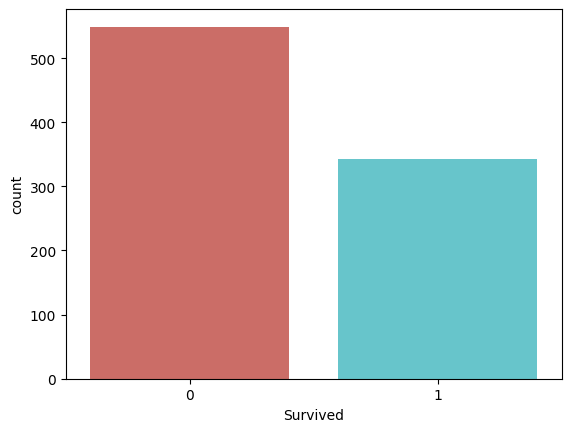

In [243]:
sb.countplot(x='Survived',data=titanic, palette='hls')

###Checking for missing values
É fácil checar missing values usando método isnull() com o método sum(), o número retornado condiz com a quantidade True para o teste, ou seja, quantidade de valores nulos nas variáveis

In [244]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [245]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Ok, então existem 891 linhas no dataframe. Cabin é quase todo composto por missing values, então podemos eliminar essa variável completamente! Mas e quanto à idade? A age parece um preditor relevante para a sobrevivência, certo? Nós queremos manter as variáveis, mas tem 177 missing values. Precisamos encontrar uma maneira de nos aproximarmos desses valores em falta!

## Lidando com missing values
#### Removendo missing values
Vamos além dos missing values... Vamos descartar todas as variáveis que não são relevantes para a predição de Survived.

In [246]:
titanic.drop(['PassengerId','Name','Ticket','Cabin'],axis=1,inplace=True)


In [247]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [248]:
titanic.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

Agora, o dataframe foi reduzido para apenas variáveis relevantes, mas agora precisamos lidar com os valores ausentes na variável age.

## Inputing missing values
Vejamos como a idade do passageiro está relacionada à sua classe como passageiro no barco.

<Axes: xlabel='Pclass', ylabel='Age'>

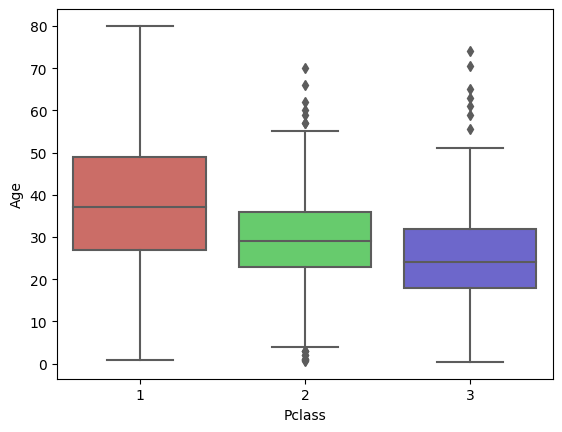

In [249]:
sb.boxplot(x='Pclass', y='Age', data=titanic, palette='hls')

Falando mais ou menos, poderíamos dizer que quanto mais jovem é um passageiro, mais provável é que ele esteja na 3ª classe. Quanto mais velho for um passageiro, maior a probabilidade de estarem na 1ª classe. Portanto, há um relacionamento frouxo entre essas variáveis. Então, vamos escrever uma função que se aproxime da idade dos passageiros, com base em sua classe. Na caixa, parece que a idade média dos passageiros de 1ª classe é de cerca de 37 anos, os passageiros de 2ª classe são 29 e os passageiros de 3ª classe são 24.

Então, vamos escrever uma função que encontre cada valor nulo na variável Age e, para cada nulo, verifique o valor da Pclass e atribua um valor de idade de acordo com a idade média dos passageiros nessa classe.

In [250]:
def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]

    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age


Após definir a função, vamos executar apenas para os valores nulos de Age

In [251]:
titanic[['Age', 'Pclass']]

,Age,Pclass
0,22.0,3
1,38.0,1
2,26.0,3
3,35.0,1
4,35.0,3
...,...,...
886,27.0,2
887,19.0,1
888,NaN,3
889,26.0,1


In [252]:
titanic[['Age', 'Pclass']].apply(age_approx, axis=1)

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888    24.0
889    26.0
890    32.0
Length: 891, dtype: float64

In [253]:
titanic['Age'] = titanic[['Age', 'Pclass']].apply(age_approx, axis=1)
titanic.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

Existem ainda 2 valores nulos na variável Embarked. Podemos eliminar esses dois registros sem perder muitas informações importantes do nosso conjunto de dados, então faremos isso.

In [254]:
titanic.dropna(inplace=True)
titanic.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [255]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


### Convertendo variaveis categóricas com one-hot-enconding (via pandas usa-se a função get_dummies)

In [256]:
aux = pd.get_dummies(titanic['Sex'],drop_first=False)
aux.head()

,female,male
0,False,True
1,True,False
2,True,False
3,True,False
4,False,True


In [257]:
gender = pd.get_dummies(titanic['Sex'],drop_first=True)
gender.head()

,male
0,True
1,False
2,False
3,False
4,True


In [258]:
embark_location = pd.get_dummies(titanic['Embarked'],drop_first=True)
embark_location.head(10)

,Q,S
0,False,True
1,False,False
2,False,True
3,False,True
4,False,True
5,True,False
6,False,True
7,False,True
8,False,True
9,False,False


In [259]:
titanic.drop(['Sex', 'Embarked'],axis=1,inplace=True)
titanic.head()

titanic_dmy = pd.concat([titanic,gender,embark_location],axis=1)
titanic_dmy.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,True,False,True
1,1,1,38.0,1,0,71.2833,False,False,False
2,1,3,26.0,0,0,7.9250,False,False,True
3,1,1,35.0,1,0,53.1000,False,False,True
4,0,3,35.0,0,0,8.0500,True,False,True


In [260]:
titanic_dmy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Age       889 non-null    float64
 3   SibSp     889 non-null    int64  
 4   Parch     889 non-null    int64  
 5   Fare      889 non-null    float64
 6   male      889 non-null    bool   
 7   Q         889 non-null    bool   
 8   S         889 non-null    bool   
dtypes: bool(3), float64(2), int64(4)
memory usage: 51.2 KB


Precisariamos fazer Feature Selection, mas faremos nas próximas aulas...


### Agora Vamos Classificar!
1º: Separar o conjunto em variável resposta e variáveis de treinamento

In [261]:
X = titanic_dmy.iloc[:,[1,2,3,4,5,6,7,8]].values
y = titanic_dmy.iloc[:,0].values

In [262]:
#X = titanic_dmy[['Age',	'SibSp',	'Parch',	'Fare',	'male'	,'S']].values
#y = titanic_dmy['Survived'].values

In [263]:
X

array([[3, 22.0, 1, ..., True, False, True],
       [1, 38.0, 1, ..., False, False, False],
       [3, 26.0, 0, ..., False, False, True],
       ...,
       [3, 24.0, 1, ..., False, False, True],
       [1, 26.0, 0, ..., True, False, False],
       [3, 32.0, 0, ..., True, True, False]], dtype=object)

In [264]:
y

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,

Agora dividir em treino e teste (teste com 30%)

In [265]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

Normalização do Conjunto

**Pergunta**: Devemos rodar o Scaler em qual conjunto de dados (completo, train ou teste)?

In [266]:
#scaler = MinMaxScaler().fit(X_train)
#scaler = StandardScaler().fit(X_train)
#scaler = MinMaxScaler().fit(X_test)

#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

In [267]:
X_train

array([[1, 31.0, 0, ..., True, False, True],
       [3, 24.0, 0, ..., True, False, True],
       [2, 24.0, 0, ..., False, False, True],
       ...,
       [1, 37.0, 0, ..., True, False, True],
       [1, 40.0, 1, ..., False, False, False],
       [2, 29.0, 1, ..., False, False, True]], dtype=object)

In [268]:
X_test

array([[1, 33.0, 0, ..., False, False, True],
       [2, 28.0, 1, ..., False, False, False],
       [3, 25.0, 1, ..., True, False, True],
       ...,
       [2, 41.0, 0, ..., False, False, True],
       [2, 28.0, 0, ..., True, False, True],
       [3, 18.0, 0, ..., False, False, True]], dtype=object)

Criação do modelo knn com o valor de k =




In [284]:
Classif_KNN = KNeighborsClassifier(n_neighbors=1)

Processo de treinamento com 70% dos dados

In [270]:
Classif_KNN.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

Processo de teste com 30% dos dados que não foram utilizados no treinamento

In [271]:
y_pred = Classif_KNN.predict(X_test)

In [272]:
y_pred

array([1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1], dtype=int64)

In [273]:
y_test

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1], dtype=int64)

###Avaliando o modelo
Analisando o rotulo real com o rotulo predito

In [274]:
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.72      0.74       164
           1       0.59      0.65      0.62       103

    accuracy                           0.69       267
   macro avg       0.68      0.68      0.68       267
weighted avg       0.70      0.69      0.70       267

0.6928838951310862


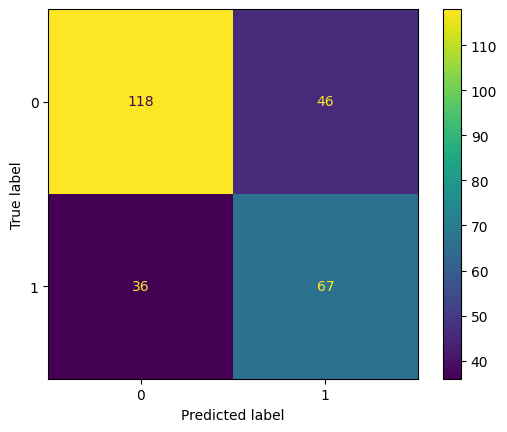

In [275]:
cm = confusion_matrix( y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

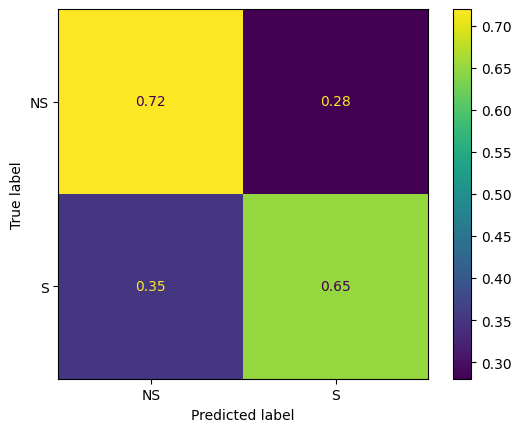

In [276]:
labels = [0,1]
label_names = ['NS', 'S']
cm = confusion_matrix( y_test, y_pred, labels = labels, normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels = label_names)
disp.plot()

Testa do K=1 até K=26


In [277]:
k_range = range(1, 26)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

[0.6928838951310862, 0.6928838951310862, 0.704119850187266, 0.6928838951310862, 0.7116104868913857, 0.7116104868913857, 0.700374531835206, 0.7078651685393258, 0.7228464419475655, 0.7303370786516854, 0.7191011235955056, 0.7078651685393258, 0.704119850187266, 0.700374531835206, 0.6891385767790262, 0.6928838951310862, 0.6928838951310862, 0.6816479400749064, 0.6891385767790262, 0.6853932584269663, 0.6853932584269663, 0.6966292134831461, 0.6853932584269663, 0.6966292134831461, 0.6704119850187266]


Text(0, 0.5, 'Testing Accuracy')

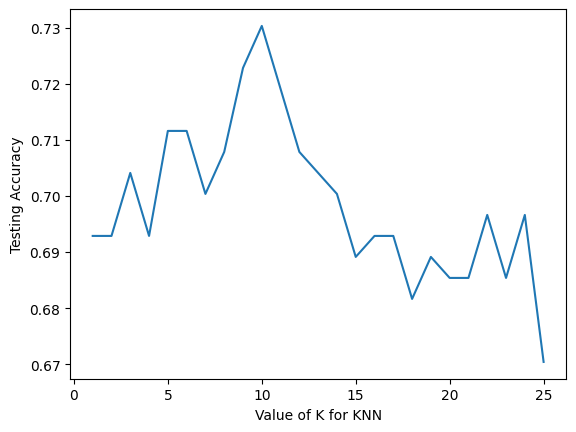

In [278]:
print(scores)
#Plota os valores de acc. em função do valor escolhido de K
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [279]:
max(scores)

0.7303370786516854

In [280]:
scores.index(max(scores))

9

In [285]:
#Avaliando a melhor configuração de KNN
best_KNN = KNeighborsClassifier(n_neighbors=9)
best_KNN.fit(X_train, y_train)
y_pred = best_KNN.predict(X_test)


In [286]:
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78       164
           1       0.66      0.59      0.62       103

    accuracy                           0.72       267
   macro avg       0.71      0.70      0.70       267
weighted avg       0.72      0.72      0.72       267

0.7228464419475655


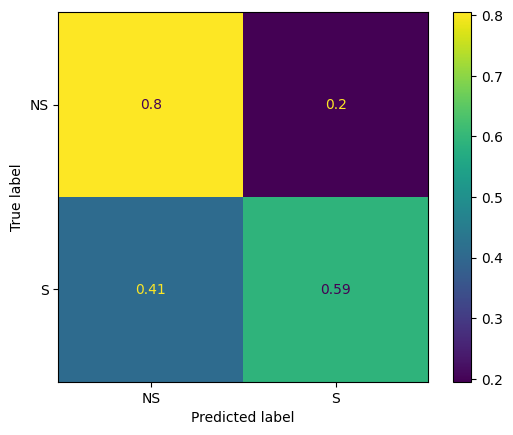

In [287]:
cm = confusion_matrix( y_test, y_pred, labels = labels, normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels = label_names)
disp.plot()

## Exercício:

Fizemos esta demonstração com o MinMaxScaler. Reproduza os estudos para os seguintes cenários: Sem Data Scaling, StandardScaler e RobustScaler

Analise os resultados e responda as seguintes perguntas:

*   Qual é o efeito do normalizador/padronizador sobre o parâmetro do classificador?
*   Qual é o efeito na matriz de confusão?
*   Qual é o efeito na acurácia?
*   Qual é o melhor na sua opinião?


## Desafio (opcional):

No estudo de varreduras do parâmetro k do `KNeighborsClassifier`, notamos algumas flutuações na acurácia do modelo. Faça uma alteração no programa para que seja possível melhorar a avaliação do melhor valor de k.


## Respostas
Qual é o efeito do normalizador/padronizador sobre o parâmetro do classificador?
Com o normalizador todos os valores de K resultam em uma acurácia maior em relação às amostras sem a normalização

Qual é o efeito na matriz de confusão?
Mesmo no melhor K sem a normalização os acertos do modelo se mostraram significativamente menores que no cenário com normalização

Qual é o efeito na acurácia?
A acurácia foi menor que no cenário com normalização

Qual é o melhor na sua opinião?
No geral a utilização do normalizador Standard se mostrou melhor na acurácia do modelo